# SpacePy Tutorial -- Epoch-Dependent Rigidity Cutoff

- https://github.com/heliophysicsPy/summer-school-24/blob/main/spacepy-tutorial/SpacePy%20-%20Cutoff%20Rigidities.md

### Background
Earth's magnetic field provides protection from high energy charged particles originating outside the magnetosphere, such as solar energetic particles (SEPs) and galactic cosmic rays (GCRs). Properties of both the particle (mass, energy, charge) and the magnetic field (strength, topology)  will determine how deep into the magnetosphere a particle can penetrate.

This example is largely inspired by ([Smart and Shea, 1993](https://adsabs.harvard.edu/full/1993ICRC....3..781S)), especially their Figure 2. It will also present the energetic charged particle data from the Global Positioning System constellation ([Morley et al., 2017](https://doi.org/10.1002/2017SW001604)).

It illustrates several areas of functionality in SpacePy and the broader scientific Python ecosystem, as well as some approaches less widely used in academic programming, including:

  - Simple file retrieval from the web
  - Working with JSON-headed ASCII ([spacepy.datamodel](https://spacepy.github.io/datamodel.html))
  - Time-system conversion ([spacepy.time](https://spacepy.github.io/time.html) and [astropy.time](https://docs.astropy.org/en/stable/time/index.html))
  - Binning 1D data into 2D with [spacepy.plot.Spectrogram](https://spacepy.github.io/autosummary/spacepy.plot.spectrogram.html)
  - The classic "traffic light" plot using [spacepy.plot.levelPlot](https://spacepy.github.io/autosummary/spacepy.plot.levelPlot.html#spacepy.plot.levelPlot)
  - Classes and inheritance

### Setup
This tutorial uses geomagnetic index and leapsecond data that SpacePy normally maintains on a per-user basis. (To download this data on your own installation of SpacePy, use [spacepy.toolbox.update()](https://spacepy.github.io/autosummary/spacepy.toolbox.html#spacepy.toolbox.update).

In [ ]:
# Update geomagnetic index and leapsecond data
import spacepy.toolbox
# spacepy.toolbox.update(all=True)

spacepy.toolbox.update(omni2=True)
spacepy.toolbox.update(leapsecs=True)

Finding OMNI2 files to download ...
Listing files ...100%
Retrieving OMNI2 files ...
Download Progress ...100%
Retrieving leapseconds file ... 


'C:\\Users\\usr\\.spacepy\\data'

> In the meantime, Steve generated up-to-date files and I've processed them into the final parsed SpacePy database. That can be downloaded [here](https://spp-isois.sr.unh.edu/data_public/omni/omnidata.h5). Place that .h5 file in the data directory inside the [Spacepy DOT_FLN directory](https://spacepy.github.io/configuration.html).

- https://github.com/spacepy/spacepy/issues/731

In [ ]:
import os
import matplotlib

import glob
import datetime as dt
import numpy as np
from scipy import constants
import matplotlib as mpl
import matplotlib.dates as mpd
import matplotlib.pyplot as plt

import spacepy.datamodel as dm
from spacepy import igrf
import spacepy.omni as om
import spacepy.plot as splot
import spacepy.time as spt

# for pretty out-of-the-box plots...
splot.style('default')

### Illustrating geomagnetic shielding using GPS particle data

To illustrate what rigidity is and does, we'll start with some energetic charged particle data from the GPS The data will download into `tutorial_data`.

In [ ]:
tutorial_data = os.path.expanduser('./spacepy_tutorial')  # Point this to wherever you want data to go.
gps_path = os.path.join(tutorial_data, 'gps')
if not os.path.isdir(gps_path):
    os.makedirs(gps_path, exist_ok=True)

In [ ]:
satnums = [64, 65, 66, 68, 69, 71]
nsdir = 'https://www.ngdc.noaa.gov/stp/space-weather/satellite-data/satellite-systems/gps/data/ns{}/'
gpspart = 'ns{}_150621_v1.10.ascii'
gpsfile = os.path.join(tutorial_data, 'gps', gpspart)

import urllib.request
for ns in satnums:
    outfile = gpsfile.format(ns)
    if not os.path.exists(outfile):
        req = urllib.request.urlretrieve(''.join([nsdir.format(ns), gpspart.format(ns)]), outfile)

This will download one file of charged particle data from each of the satellites listed (ns64, etc.), which have a Combined X-ray Dosimeter (CXD) on board that measures energetic electrons and protons. The data is provided using an ASCII format that is self-describing. Think of it as implementing something like HDF5 or NASA CDF in a text file. The metadata and non-record-varying data are stored in the header to the ASCII file, which is encoded using JSON (JavaScript Object Notation). There's a convience routine to read these in `spacepy.datamodel`.

In [ ]:
gps = dm.readJSONheadedASCII(gpsfile.format(71))

In [ ]:
type(gps)

spacepy.datamodel.SpaceData

This reads the file all-at-once into a `spacepy.datamodel.SpaceData`, which is a dictionary that also carries metadata. The data are then stored as arrays (`spacepy.datamodel.dmarray`) that also carry metadata. We can quickly inspect the contents with the `.tree()` method, and can also see data types and metadata entries at-a-glance by adding the `verbose` and `attrs` keywords.

In [ ]:
gps.tree(verbose=True, attrs=True)

+
:|____Code_version_used (str [4])
:|____Contact1 (str [40])
:|____Contact2 (str [40])
:|____Contact3 (str [42])
:|____Copyright (str [1137])
:|____Data_Origin (str [0])
|____Geographic_Latitude (spacepy.datamodel.dmarray (2520,))
    :|____DESCRIPTION (str [19])
    :|____DIMENSION (list [1])
    :|____ELEMENT_LABELS (list [1])
    :|____ELEMENT_NAMES (list [1])
    :|____FILL_VALUE (float)
    :|____LABEL (str [29])
    :|____NAME (str [19])
    :|____START_COLUMN (int)
    :|____TITLE (str [19])
    :|____UNITS (str [7])
|____Geographic_Longitude (spacepy.datamodel.dmarray (2520,))
    :|____DESCRIPTION (str [20])
    :|____DIMENSION (list [1])
    :|____ELEMENT_LABELS (list [1])
    :|____ELEMENT_NAMES (list [1])
    :|____FILL_VALUE (float)
    :|____LABEL (str [30])
    :|____NAME (str [20])
    :|____START_COLUMN (int)
    :|____TITLE (str [20])
    :|____UNITS (str [7])
|____LEP_thresh (spacepy.datamodel.dmarray (2520,))
    :|____DESCRIPTION (str [40])
    :|____DIMENSION (li

Most commonly we deal with times expressed in UTC, that is, Coordinated Universal Time. UTC is the reference time for everyday life. However, UTC isn't a continuous time scale with a constant number of seconds per day. Sometimes leap seconds are applied, and these aren't known years in advance. So a lot of applications and operational systems will use time scales that don't use leap seconds. Common scales include TAI (International Atomic Time), GPS (Global Positioning System) time, and nanoseconds since the J2000 epoch.

Our GPS particle data file has the time written out in GPS time, so we want to convert that to UTC.


But first, if we just interpret the year and decimal day as being UTC what would we get? Let's try it. We can use `spacepy.toolbox.doy2date` here to convert from a fractional Day of Year to a datetime.

In [ ]:
datearray = spt.doy2date(gps['year'].astype(int), gps['decimal_day'], dtobj=True, flAns=True)
print(datearray[0])

2015-06-21 00:03:55.008000


But this doesn't take leap seconds into account. Since the zero epoch of the GPS time scale is defined as 1980-01-06T00:00:00 UTC we can convert the GPS date/time into "GPS seconds", which is a fairly standard way of expressing the system. That is, seconds since the GPS zero epoch.

Once we know the GPS seconds, we can get UTC (or other time systems) from either `spacepy.time.Ticktock` or `astropy.time.Time`.

In [ ]:
def ticks_from_gps(year, decday, use_astropy=False):
    '''Get a Ticktock from the year and decimal day in GPS time

    Notes
    -----
    1 - The decimal day is given as "GPS time" which is offset
    from UTC by the number of leapseconds since 1980.
    2 - The timestamps correspond to the midpoints of the integration
    intervals
    '''
    intyear = year.astype(int)
    datearray = spt.doy2date(intyear, decday, dtobj=True, flAns=True)
    # this is GPS time, so needs to be adjusted by leap seconds
    GPS0 = dt.datetime(1980, 1, 6)  # Zero epoch for GPS seconds system
    gpsoffset = datearray - GPS0
    gpsseconds = [tt.total_seconds() for tt in gpsoffset]
    if not use_astropy:
        return spt.Ticktock(gpsseconds, dtype='GPS')
    else:
        import astropy.time
        return astropy.time.Time(gpsseconds, format='gps')

In [ ]:
gpticktock = ticks_from_gps(gps['year'], gps['decimal_day'])
print(gpticktock.UTC[0], type(gpticktock))

2015-06-21 00:03:39.008000 <class 'spacepy.time.Ticktock'>


`spacepy.time.Ticktock` manages things internally as TAI, but the string representation is assumed to be UTC for input and output. So if we print the string (ISO8601 format) we get:

In [ ]:
print(gpticktock.ISO[0])

2015-06-21T00:03:39


This is missing the milliseconds that we saw above. What's happening is that the precision shown by `.ISO` defaults to seconds. It's just a display setting, so let's show the full precision.

In [ ]:
gpticktock.isoformat('microseconds')
print(gpticktock.ISO[0])

2015-06-21T00:03:39.008000


If you are using astropy or sunpy then you may want the time as an `astropy.time.Time`, so let's check that our times agree.

In [ ]:
gpastro = ticks_from_gps(gps['year'], gps['decimal_day'], use_astropy=True)
print(gpastro.iso[0], type(gpastro))
# For reasons about to become clear, we'll also print the "scale"
print('Our astropy Time object uses the {} scale'.format(gpastro.scale))

2015-06-21 00:04:14.008 <class 'astropy.time.core.Time'>
Our astropy Time object uses the tai scale


**This does not agree with our previous answers?! Why?**

GPS time is basically a fixed offset from TAI. So when you tell astropy that the format is "gps" it makes a `Time` object on the TAI scale (if you're really interested, you can [read an issue on astropy's github](https://github.com/astropy/astropy/pull/1879) that discusses this). Each are the number of seconds from a zero epoch, without leap seconds. GPS has a later epoch and so is offset by the total number of leap seconds in January 1980. So the "iso" representation here is of TAI represented as an ISO-formatted date and time, and not of either GPS _or_ UTC. Hence it's 19 seconds ahead of the GPS representation we started with...

We can change the scale to UTC and re-run the cell to check that it agrees with our calculated UTC time:

In [ ]:
print(gpastro.utc.iso[0], type(gpastro))

2015-06-21 00:03:39.008 <class 'astropy.time.core.Time'>


Note that you can make a `spacepy.time.Ticktock` directly from an `astropy.time.Time` by specifying the `APT` datatype on instantiation. For convenience moving forward, let's add this to our GPS data collection. We can also verify that we still have the same times... so go ahead and copy the code below into the next (empty) cell and run it.

In [ ]:
gps['Time'] = spt.Ticktock(gpastro, dtype='APT')
print(gps['Time'].UTC[0], type(gps['Time']))
gps['Time'].isoformat('microseconds')  # set this for display purposes later

2015-06-21 00:03:39.008000 <class 'spacepy.time.Ticktock'>


**Question: If we have times as a `spacepy.time.Ticktock`, how can we convert that to an `astropy.time.Time`?**

In [ ]:
astrotime = gps['Time'].APT

Yes, it's that simple. `astropy.time.Time` is supported both as an input data type and an output data type.

In [ ]:
# replace the following line with the code from the example above
# this line is here is case you just want to hit "run all"
gps['Time'] = spt.Ticktock(gpastro, dtype='APT')

### Showing geomagnetic shielding of solar energetic particles
Let's plot some GPS proton data!

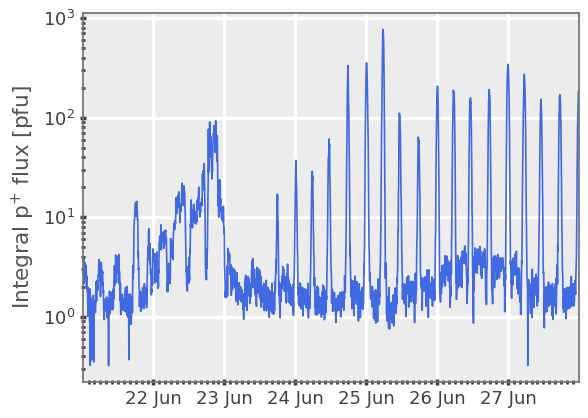

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.semilogy(gps['Time'].UTC, gps['proton_integrated_flux_fit'][:, 0])
ax.set_ylabel('Integral p$^{+}$ flux [pfu]')
_ = splot.applySmartTimeTicks(ax, gps['Time'].UTC)

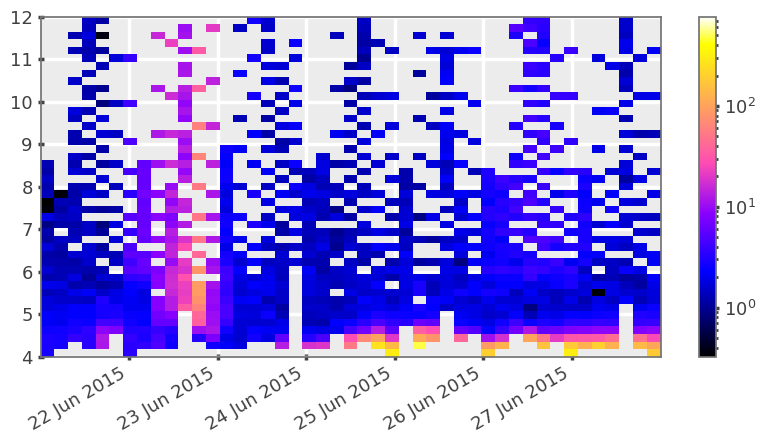

In [ ]:
specdata = dm.SpaceData()
mask = gps['proton_integrated_flux_fit'][:, 2] > 0
mask = np.logical_and(mask, gps['L_LGM_T89IGRF'] < 20)
specdata['L'] = gps['L_LGM_T89IGRF'][mask]
specdata['Time'] = gps['Time'].UTC[mask]
specdata['Data'] = gps['proton_integrated_flux_fit'][mask, 0]

spec = splot.Spectrogram(specdata, variables=['Time', 'L', 'Data'],
                         ylim=[4, 12],
                         extended_out=True)
ax2 = spec.plot(figsize=(10, 5), cmap='gnuplot2')

Since we didn't specify bin sizes, these are automatically estimated. And because we didn't set limits on the time range, we're seeing the full range in the file (i.e., a week). One thing that should stand out here is the SEP event on June 23rd where the flux increases at a broad range of L. The other thing to note is that after the SEP we see a strong increase in proton flux at low L. This could be one of two things:
  1. Energetic electrons from the SEP trapped at low L
  2. Contamination from relativistic electrons as the radiation belt is enhanced by activity following the SEP

The latter is actually more likely, and it is left as an exercise to check this...

- The P3 channel is sensitive to relativistic electrons and is often contaminated during very active intervals in the radiation belt. We can look at the P3 counts compared to the P1 counts to see whether both show an increase at low L.
- As the electron fluxes are also provided in the GPS data files, we can make similar `spacepy.plot.Spectrogram` plots for electron fluxes at 1-2 MeV. As the ~1MeV flux increases, we should also see the low L proton flux increase if it's contamination.

Another thing to check here is the geomagnetic activity, which we can do here using `spacepy.omni`. A geomagnetic storm visible in the Dst index, or a period of elevated Kp would suggest that the radiation belts are likely to be enhanced.
So let's take a quick look at the geomagnetic activity measured by Kp, just to demonstrate `spacepy.plot.levelPlot`.
SpacePy includes the low-resolution OMNI data via `spacepy.omni`, so let's make an hourly time array and load Kp (which is a 3-hourly index).


Text(0, 0.5, 'Kp')

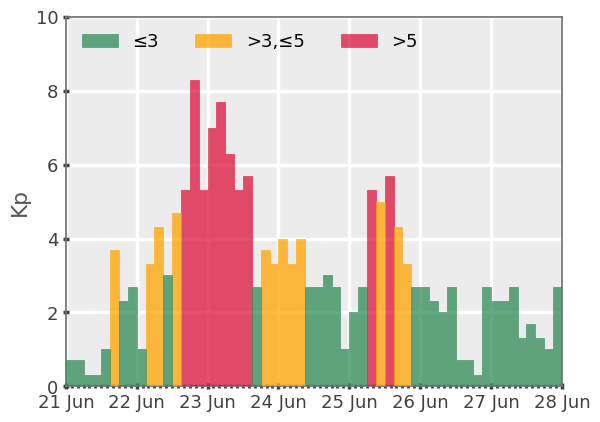

In [ ]:
# spacepy.time.tickrange can also take datetime/timedelta inputs
t0 = dt.datetime(2015, 6, 21)
t1 = dt.datetime(2015, 6, 28)
delt = dt.timedelta(hours=1)
kptimes = spt.tickrange('2015-06-21', '2015-06-28', delt)

omdata = om.get_omni(kptimes)
ax = splot.levelPlot(omdata,
                     var='Kp', time='UTC',
                     legend=True,
                     colors=['seagreen', 'orange', 'crimson'])
ax.set_ylim([0, 10])
ax.set_ylabel('Kp')

In [ ]:
# Explicitly set bin sizes
# Time bins are 90 minutes
tstart = '2015-06-22T12:00:00'
tend = '2015-06-23T00:00:00'
tbins = spt.tickrange(tstart, tend, deltadays=1.5/24).UTC
# L bins are variable 1/8, 1/4, and 1
ybins = np.hstack([np.arange(4, 5, 0.125),
                   np.arange(5, 6.5, 0.25),
                   np.arange(6.5, 13, 1)])  # uneven bins are allowed!

spec = splot.Spectrogram(specdata, variables=['Time', 'L', 'Data'],
                         bins=[tbins, ybins],
                         xlim=spt.Ticktock([tstart, tend]).UTC.tolist(),
                         ylim=[4, 8],
                         extended_out=True)

So now that we've explicitly made our `Spectrogram` again, but this time with explicit bins and limits, let's add the data from the other satellites to fill out the figure.

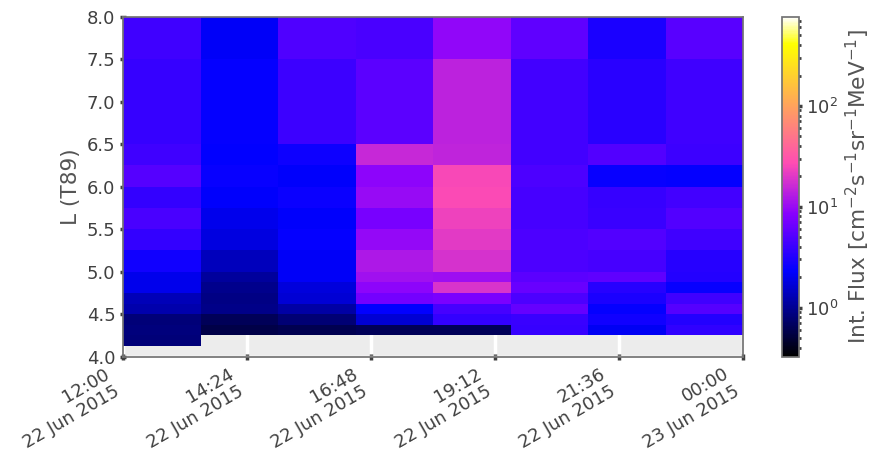

In [ ]:
for sat in satnums:
    gpsmulti = dm.readJSONheadedASCII(gpsfile.format(sat))
    adata = dm.SpaceData()
    gpsmulti['Time'] = ticks_from_gps(gpsmulti['year'], gpsmulti['decimal_day'])
    mask = gpsmulti['proton_integrated_flux_fit'][:, 2] > 0
    mask = np.logical_and(mask, gpsmulti['L_LGM_T89IGRF'] < 20)
    adata['L'] = gpsmulti['L_LGM_T89IGRF'][mask]
    # the date2num conversion is needed for matplotlib version >= 3.3
    # until we provide a fix in spacepy
    adata['Time'] = mpd.date2num(gpsmulti['Time'].UTC[mask])
    adata['Data'] = gpsmulti['proton_integrated_flux_fit'][mask, 2]
    spec.add_data(adata)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
_ = spec.plot(target=ax, cmap='gnuplot2',
              ylabel='L (T89)',
              DateFormatter=mpd.DateFormatter('%H:%M\n%d %b %Y'),
              colorbar_label='Int. Flux [cm$^{-2}$s$^{-1}$sr$^{-1}$MeV$^{-1}$]')

Rather than using `add_data` to loop over the files, we could make this figure "at-once".

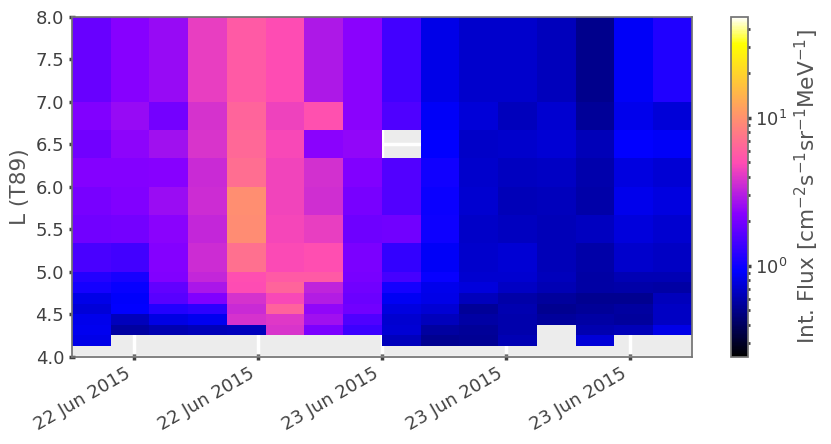

In [ ]:
# start by making axes to display the data
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
# get all of the gps filenames
fns = glob.glob(os.path.join(os.path.join(tutorial_data, 'gps'), 'ns*ascii'))
# and now read them all-at-once, this will concatenate the files in the read order
gpsmulti = dm.readJSONheadedASCII(fns)

# now we just make the Spectrogram object as before
gpsmulti['Time'] = ticks_from_gps(gpsmulti['year'], gpsmulti['decimal_day'])
mask = gpsmulti['proton_integrated_flux_fit'][:, 2]> 0
mask = np.logical_and(mask, gpsmulti['L_LGM_T89IGRF'] < 20)

specdata = dm.SpaceData()
specdata['L'] = gpsmulti['L_LGM_T89IGRF'][mask]
specdata['Time'] = gpsmulti['Time'].UTC[mask]
specdata['Data'] = gpsmulti['proton_integrated_flux_fit'][mask, 2]

# Explicitly set bin sizes
# Time bins are 90 minutes
tstart = '2015-06-22T12:00:00'
tend = '2015-06-23T12:00:00'
tbins = spt.tickrange(tstart, tend, deltadays=1.5/24).UTC
# L bins are variable 1/3, 1/2, and 1
ybins = np.hstack([np.arange(4, 5, 0.125),
                   np.arange(5, 7, 1/3),
                   np.arange(7, 9, 1)])  # uneven bins are allowed!

spec = splot.Spectrogram(specdata, variables=['Time', 'L', 'Data'],
                         bins=[tbins, ybins],
                         xlim=spt.Ticktock([tstart, tend]).UTC.tolist(),
                         ylim=[4, 8],
                         extended_out=True)
_ = spec.plot(target=ax, cmap='gnuplot2',
              ylabel='L (T89)',
              colorbar_label='Int. Flux [cm$^{-2}$s$^{-1}$sr$^{-1}$MeV$^{-1}$]')

As you can see, throughout the SEP interval the fluxes at higher L remain elevated. At lower L the fluxes start to drop. This is due to more of the lower energy particles being excluded due to the higher magnetic field strength, thus the overall flux drops. Looking at the temporal variation, the flux is high at L values above about 5 at the start of the SEP. As the storm gets going the flux enhancement penetrates to lower L. This is geomagnetic activity changing the effective field strength and thus modifying the shielding.

For further examples using the GPS proton measurements, see [Chen et al., 2018](https://doi.org/10.1029/2019JA027679) and [van Hazendonk et al., 2022](https://doi.org/10.1029/2021JA030166). For more information on the electron data and their application, see [Morley et al., 2016](https://doi.org/10.1002/2015SW001339), [Olifer et al., 2019](https://doi.org/10.1029/2018JA026348), and [Smirnov et al., 2020](https://doi.org/10.1029/2020SW002532).

### Modeling Particle Access
Störmer derived a closed-form solution for the minimum rigidity that at any point and direction of arrival in a dipole magnetic field. This minimum, or _cutoff_, rigidity (R<sub>C</sub>) takes the following form (cf. [Smart and Shea, 1993](https://adsabs.harvard.edu/full/1993ICRC....3..781S) and ([O'Brien et al., 2018](https://doi.org/10.1029/2018SW001960))):

R<sub>C</sub> = M / L<sup>2</sup>[1 + (1 - sin ε sin ζ cos<sup>3</sup> λ)<sup>½</sup>]<sup>2</sup>

where M is the dipole moment, L is the dipole L (a dimensionless "distance" parameter that describes the field line), λ is the magnetic latitude, and ε and ζ are angles describing the arrival direction of the particle.

While the Störmer model takes the direction into account, we'll just use the vertical approximation for our calculations to save on code. A lot of sources will replace M with 4R<sub>0</sub>, where R<sub>0</sub> is the vertical cutoff rigidity at L-1. For a full implementation [see the SHIELDS-PTM code](https://github.com/lanl/SHIELDS-PTM).
<!-- #endregion -->

We'll be using the `IGRF` module in SpacePy to evaluate Earth's dipole moment. Currently this isn't a fully-featured IGRF implemenation - it supports the coordinate system transformations and so we can get the dipole axis and the magnetic moment. First we need to make an IGRF object, then initialize it for a specific time.

**Before you run the next cell, any guesses on roughly what the magnetic moment is?**

In [ ]:
magmod = igrf.IGRF()
magmod.initialize(gps['Time'][0])
print('The centered dipole magnetic moment at {} is {:0.2f} nT'.format(gps['Time'].ISO[0], magmod.moment['cd']))

The centered dipole magnetic moment at 2015-06-21T00:03:39 is 29861.53 nT


In [ ]:
def get_stormer_coefficient(cd_moment):
    """Set rigidity coefficient as dipole moment in mixed units

    See section 2 of Smart and Shea (1993).

    References
    ----------
    - Smart, D. F. and Shea, M. A., “The Change in Geomagnetic Cutoffs Due to
      Changes in the Dipole Equivalent of the Earth's Magnetic Field”, in
      23rd International Cosmic Ray Conference (ICRC23), Volume 3, 1993, p. 781.
    """
    re_cm = 6371.0008*1e5  # Volumetric Earth radius in cm
    mom_gauss_cm3 = (cd_moment/1e5)*re_cm**3
    gauss_cm = mom_gauss_cm3/re_cm**2
    # Now apply unit conversion, eV to Gev and volts to abvolts
    coeff = 300*gauss_cm/1e9
    coeff_v = coeff/4  # vertical reduction
    return coeff_v

### Impact of varying dipole moment
The Störmer model of geomagnetic rigidity cutoff depends on the strength of the Earth's dipole moment. This varies with time, although commonly the values are taken for reference epochs. E.g., the commonly-used value of 60 corresponds to a reference epoch around 1932. For the case of vertically-incident particles the equation can be simplified and a factor of 4 appears in the denominator. Thus this is often presented as a coefficient with a value of 15. Later work by Smart and Shea uses a vertically-incident coefficient of 14.5. This corresponds to a reference epoch of around 1988.

To bring previous explorations of how the time-varying dipole moment impacts the coefficient used in the Störmer model, we'll graph the variation with time here.


For this work we need to convert between particle energy, and particle _rigidity_. I'm borrowing the `Particle` class from our particle tracing code `SHIELDS-PTM` as an illustration of how to make simple classes and re-use them.

In [ ]:
from abc import ABC, abstractmethod

# This is from the ptm_python.ptm_tools in the SHIELDS-PTM repository
class Particle(ABC):
    """Generic particle container

    Subclass to make proton, etc.
    """
    @abstractmethod
    def __init__(self):
        self._checkvalues()

    def _checkvalues(self):
        assert self.energy
        assert self.charge
        assert self.restmass
        assert self.mass

    def getRigidity(self, units='GV'):
        """Calculate rigidity in GV

        Energy & rest mass energy are in MeV
        Mass is in atomic mass number
        Charge is in units of elementary charge (proton is 1, electron is -1)
        """
        mcratio = self.mass/self.charge
        en_part = self.energy**2 + 2*self.energy*self.restmass
        rigidity_MV = mcratio * np.sqrt(en_part)
        if units.upper() == 'GV':
            rigidity = rigidity_MV/1e3
        else:
            raise NotImplementedError('Units other than GV for rigidity are not supported')
        return rigidity

    @classmethod
    def fromRigidity(cls, rigidity_GV):
        """Given rigidity in GV, make particle
        """
        rmv = rigidity_GV*1e3
        asq = cls.mass**2
        rmsq = cls.restmass**2
        csq = cls.charge**2
        part = asq*(asq*rmsq + csq*rmv**2)
        e_k = (np.sqrt(part) - asq*cls.restmass)/asq
        return cls(e_k)

Now that we have an abstract class for _any_ particle, let's make one specifically for protons. When using physical constants it's a good idea to be both consistent and precise. A lot of useful constants are given in `scipy.constants`.

In [ ]:
class Proton(Particle):
    charge = 1
    mass, _, _ = constants.physical_constants['proton mass in u']  # AMU
    restmass, _, _ = constants.physical_constants['proton mass energy equivalent in MeV']

    def __init__(self, energy):
        self.energy = energy
        super().__init__()

So how does this work? The `classmethod` means that we expect to use the method without directly making a `Particle` first. Calling `Proton.fromRigidity` will make a `Proton`.

In [ ]:
rigidity = 0.5  # GV
myproton = Proton.fromRigidity(rigidity)
print('{:.3f} GV rigidity in a proton corresponds to {:.3f} MeV energy'.format(rigidity, myproton.energy))

0.500 GV rigidity in a proton corresponds to 123.215 MeV energy


If we know the energy, we can make a `Proton` directly and then calculate the rigidity.

In [ ]:
anotherproton = Proton(myproton.energy)
print('And converting back to rigidity, we recover {:.7g} GV'.format(anotherproton.getRigidity()))

And converting back to rigidity, we recover 0.5 GV


**Exercises: What would classes for electrons and O<sup>2+</sup> look like?**

Now we'll instatiate an IGRF object and set up an array of times that we want to evaluate the magnetic moment at.

IGRF13 currently covers the period 1900 to 2025, so we can update the results presented by Smart and Shea to use one consistent model from 1900 through 2025. In their paper, pre-1945 was taken from work by Akasofu and Chapman (1972) and the last year shown was 1990. As the IGRF can be slow to evaluate and the magnetic moment veries slowly, we'll do one data point every 90 days. This give us approximately 500 points sampled over the data range, compared to the 16 used by Smart and Shea.

In [ ]:
magmod = igrf.IGRF()
epochs = spt.tickrange('1900-1-1', '2025-1-1', 90)
print('Number of epochs is {}'.format(len(epochs)))

Number of epochs is 508


The next step is to loop over the times and, for each, calculate the moment of the centered dipole. This might take a couple of seconds as evaluating IGRF is relatively computationally expensive.


In [ ]:
moments = np.empty(len(epochs))
for idx, tt in enumerate(epochs):
    magmod.initialize(tt)
    moments[idx] = (magmod.moment['cd'])

The coefficient used in the vertical simplification of the Störmer model is equivalent to the cutoff rigidity for vertical incidence at L=1. This would be multiplied by 4 to obtain the moment in the mixed units used by Störmer.

In [ ]:
def cutoff_at_L(l_value, cd_moment):
    """Cutoff rigidity at given L for Stormer vertical approximation

    Parameters
    ==========
    l_value : float or array of floats
        L at which to evaluate the cutoff
    cd_moment : float or array of floats
        centered dipole moment of epoch

    Returns
    =======
    cutoff : float or array of floats
        Geomagnetic cutoff at given dipole L. Units are in GV.
    """
    l_vals = np.atleast_1d(l_value)
    cutoff = get_stormer_coefficient(cd_moment)/l_vals**2
    return cutoff

lvals = [1]
cutoffs = np.empty([len(epochs), len(lvals)])
for idx, mm in enumerate(moments):
    cutoffs[idx, :] = cutoff_at_L(lvals, mm)

Having obtained the array of cutoff rigidities (or, equivalently, the coefficient for vertical incidence) as a function of epoch, we can plot these. We'll also convert the rigidities used in the tick labels to cutoff energy (assuming protons).

As the values 15 and 14.5 are commonly used in the literature, let's see what epochs these actually correspond to and mark those on the plot too...

Text(629.3194444444445, 0.5, 'Proton Energy [GeV]')

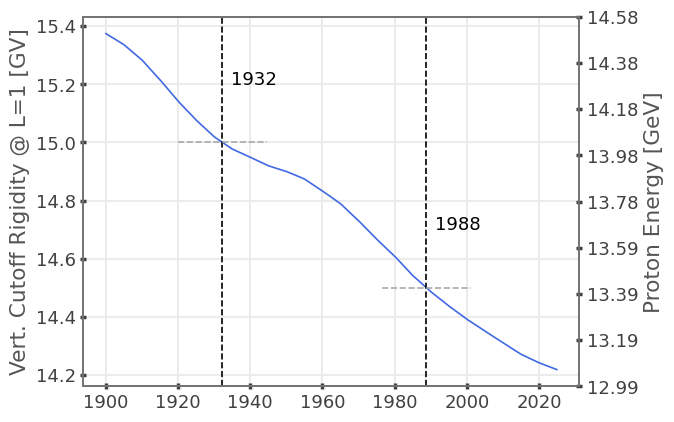

In [ ]:
splot.style('altgrid')
# first get the indices where the vertical cutoff rigidity
# is closest to our target values
ind15 = np.argmin(np.abs(cutoffs - 15))
ind14p5 = np.argmin(np.abs(cutoffs - 14.5))

# make our figure and plut vertical cutoff vs. time
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(epochs.UTC, cutoffs)
# add labels, text annotations, etc.
ax.set_ylabel('Vert. Cutoff Rigidity @ L=1 [GV]')
ax.axvline(epochs.UTC[ind15], c='k', ls='--')
ax.axvline(epochs.UTC[ind14p5], c='k', ls='--')
ax.hlines(14.5, epochs.UTC[ind14p5-50], epochs.UTC[ind14p5+50], colors='darkgrey', ls='--')
_ = ax.hlines(15, epochs.UTC[ind15-50], epochs.UTC[ind15+50], colors='darkgrey', ls='--', zorder=99)
_ = ax.text(epochs.UTC[ind15+10], 15.2, epochs.UTC[ind15].year)
_ = ax.text(epochs.UTC[ind14p5+10], 14.7, epochs.UTC[ind14p5].year)
# now let's add the second y-axis
ax2 = ax.twinx()
ax2.grid(False)
ax2.set_ylim(ax.get_ylim())  # match axes
# so that the tick labels are populated we need to "draw"
plt.draw()
# freeze the ticks so we can label them
ax2.set_yticks(ax2.get_yticks())
rig_vals = ax2.get_yticklabels()
ax2.set_yticklabels(['{:.2f}'.format(Proton.fromRigidity(float(rr.get_text())).energy/1e3) for rr in rig_vals])
ax2.set_ylabel('Proton Energy [GeV]')

At this point, let's undo the SpacePy plot style that we applied. This will take us back to the matplotlib defaults.
For our final figure we'll show what the vertical cutoff rigidity is, and how it's varied in time, at L=[6, 7, 8].

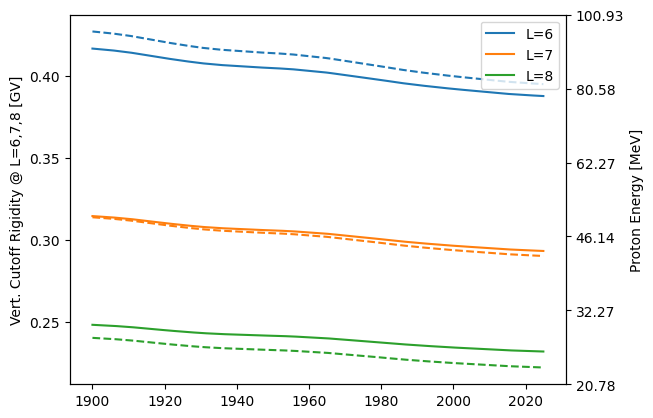

In [ ]:
# reset plot style
splot.revert_style()

# now for our last figure
lvals = [6, 7, 8]
cutoffs = np.empty([len(epochs), len(lvals)])
for idx, mm in enumerate(moments):
    cutoffs[idx, :] = cutoff_at_L(lvals, mm)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(epochs.UTC, cutoffs, ls='--')
ax = plt.gca()
ax2 = ax.twinx()
ax2.grid(False)
ax.set_ylabel('Vert. Cutoff Rigidity @ L=6,7,8 [GV]')
ax2.set_ylim(ax.get_ylim())
plt.draw()
for idx, lv in enumerate(lvals):
    ax2.plot(epochs.UTC, cutoffs[:, idx], label='L={}'.format(lv))
ax2.set_yticks(ax2.get_yticks())
rig_vals = ax2.get_yticklabels()
ax2.set_yticklabels(['{:.2f}'.format(Proton.fromRigidity(float(rr.get_text())).energy) for rr in rig_vals])
ax2.set_ylabel('Proton Energy [MeV]')
ax2.legend()
plt.show()

Finally, let's imagine that a collaborator wants the vertical cutoff rigidity at L=[6, 7, 8], for the full time range we've looked at. But they want data in HDF5. This is mercifully straightforward using `spacepy.datamodel`:
- As long as we have a `SpaceData` that contains our data arrays as `dmarray`, we can write HDF5 (or CDF, or JSON-headed ASCII) with one line.

Let's make this with some metadata that follows, in a very incomplete way, the [NASA ISTP metadata guidelines](https://spdf.gsfc.nasa.gov/istp_guide/istp_guide.html)... (see also [spacepy.pycdf.istp](https://spacepy.github.io/autosummary/spacepy.pycdf.istp.html) for explicit support/helpers for ISTP-compliant CDF)

In [ ]:
outdata = dm.SpaceData(attrs={'Notes': 'I made this.', 'Creation Date': '{}'.format(spt.Ticktock.now().ISO)})
outdata['Epoch'] = epochs.UTC
outdata['Rc'] = dm.dmarray(cutoffs, attrs={'DEPEND_0': 'Epoch',
                                           'DEPEND_1': 'L',
                                           'UNITS': 'GV'})
outdata['L'] = dm.dmarray(lvals)

outdata.toHDF5('yourUniqueFilenameHere.h5')  # you'll obviously want to change what this is called

If you have a few moments. Try reading the file back in and exploring the data and metadata. Perhaps write as a different file type (CDF, JSON-headed ASCII) and spot any differences in how things are stored or represented.